# FOURSQUARE PROJECT

## LIVING IN CINCY

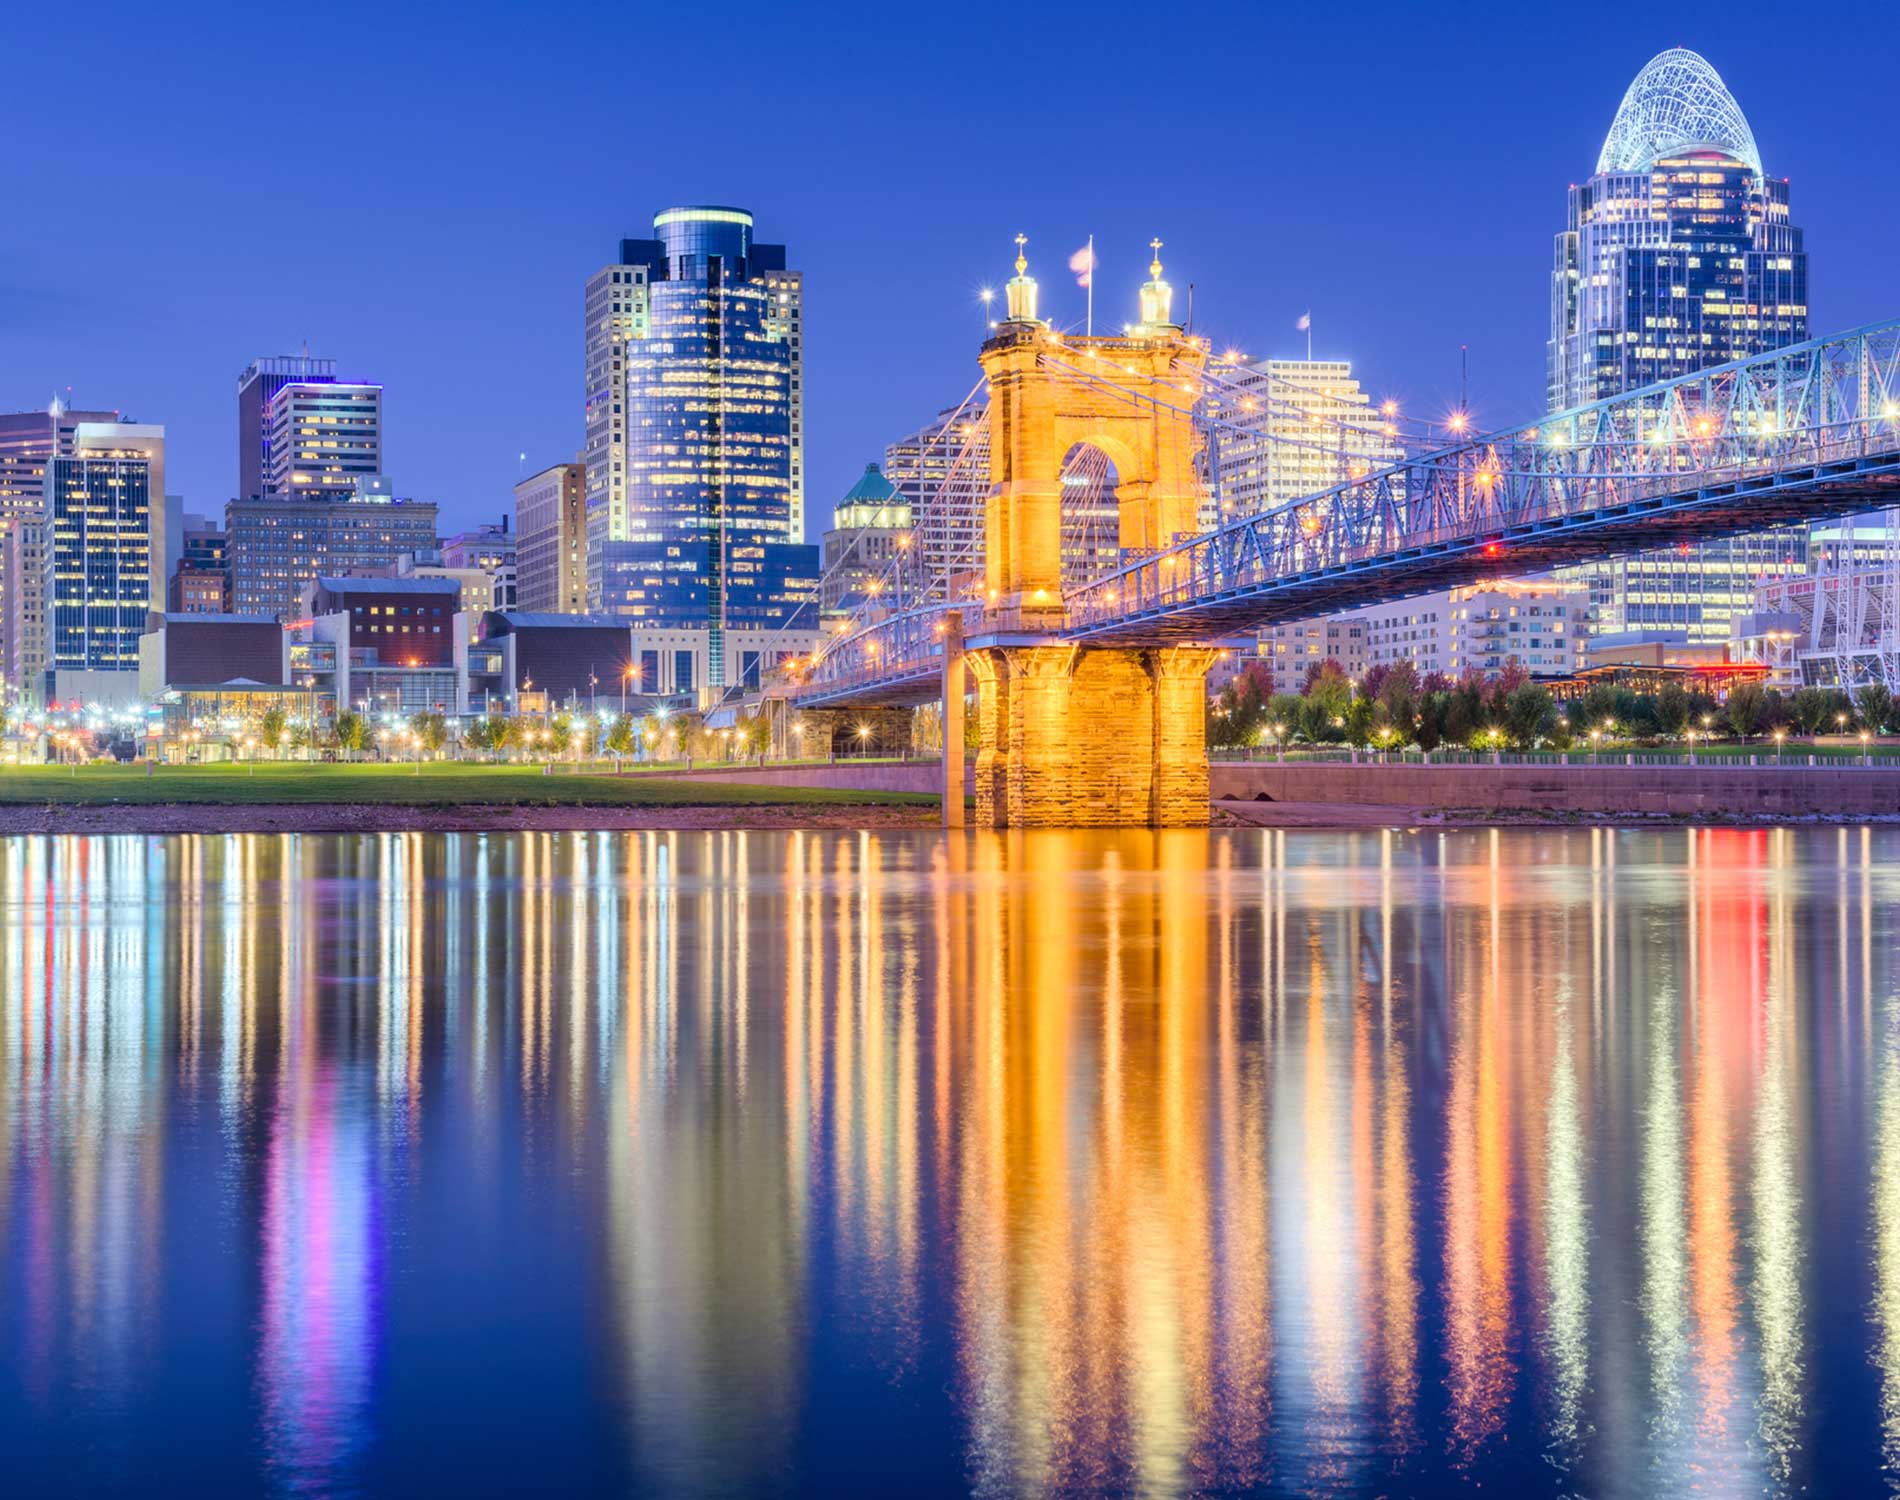

*Picture Source*

https://www.dentons.com/en/global-presence/united-states/cincinnati

*About Cincinnati*

https://www.newhomesource.com/learn/cincinnati-relocation-guide/

## WHICH IS THE BEST NEIGHBORHOOD TO LIVE IN CINCINNATI BASED OH THEIR VENUES?

## In this project we'll go through some essencial steps in a Data Science Project

   *1 - Introduction* 
   
        -About the city.
   
   *2 - Business Understanding*
   
        -Problem Description;
        -Goals;
                
   *3 - Data Requirements*
   
        -Analysing what kind of data we need to solve the problem.
    
   *4 - Data Collection;*
   
        -Web Scraping of Wikipedia;
        -Cleaning the data;
        -Getting Coordinates using Geocode with ArcGis;
        -Visualizing the neighborhoods in a Folium Map;
        -Getting venues from Foursquare API using the neighborhoods coordinates.
        

   *5 - Exploratory Data Analysis*
   
        -Exploring the dataset features;
        -Visualizing the venues in a map;
        -Plotting the top 15 venues' categories;
        -Plotting the top 15 restaurants;
        -Visualizing some distances using Polyline.
        
   *6 - Featura Engineering*
   
        -Selecting the useful data;
        -Generating a pandas dataframe;
        -Searching for missing values;
        -Looking at the data format of each column;
        -Counting the venues' categories;
        -Reorganize the categories;
        -Applying the StandardScaler;
        -Saving a new .csv file.
        
   *7 - Modeling the data*
   
        -Applying the elbow methos;
        -Applying the silhouette method;
        -Applying K-Means algorithm.
        
   *8 - Model Evaluation*
   
        -Analyzing the clusters;
        -Discussions;
        -Conclusion.
        

#### Token and ID's to access Foursquare API

In [1]:
# @hidden_cell
CLIENT_ID = 'VEFGBQVOPGZUPTV43N5W102TH4UOAZK31GPOQOGDH2VDJJIT' # your Foursquare ID
CLIENT_SECRET = 'A44LL43ZDCQYBICI3WFVHDNR5F3SIL5C0H0CCEET1KMF4WCA' # your Foursquare Secret
ACCESS_TOKEN = 'C4XV2SP3UETUTTZENGZYHSR1HXJP2SVSLQ0HEZJT3Z1PN1RR' # your FourSquare Access Token
VERSION = '20180604'

#### Libraries imported

In [2]:
#!pip install geopy
#!pip install folium==0.5.0
#!pip install geocoder

In [3]:
import pandas as pd
import json
import requests
import folium
import geocoder
import geopy
from bs4 import BeautifulSoup
from geopy.geocoders import Nominatim

#from pandas.core.frame import DataFrame
#pd.set_option('display.max_columns', None)
#pd.set_option('display.max_rows', None)
#from pandas.io.json import json_normalize
#import matplotlib.cm as cm
#import matplotlib.colors as colors

## Scraping the names of districts and their neighborhoods in Cincinatti from Wikipedia

In [4]:
url = 'https://en.wikipedia.org/wiki/List_of_Cincinnati_neighborhoods#List'
page = requests.get(url).text
soup = BeautifulSoup(page, 'lxml')

In [5]:
dist = soup.find_all('span', {'class':'mw-headline'})
distrito = [] #to feed district list
for x in dist:
  distrito.append(x.text)

distrito = distrito[1:6]

In [6]:
#searching for the neighborhood names
ol = soup.find_all("li")
#this list will keep the district correlated with each neighboorhood
dic = [] 
one = [ol[12].find("a").text, ol[22].find("a").text, ol[23].find("a").text,
       ol[30].find("a").text, ol[31].find("a").text, ol[32].find("a").text]

for neig in one:
    dic.append(distrito[0])

two = [ol[39].find("a").text, ol[40].find("a").text, ol[42].find("a").text,
       ol[43].find("a").text, ol[46].find("a").text, ol[49].find("a").text,
       ol[52].find("a").text, ol[53].find("a").text, ol[54].find("a").text, 
       ol[55].find("a").text, ol[56].find("a").text,
       ol[57].find("a").text, ol[59].find("a").text]

for neig in two:
    dic.append(distrito[1])
    
three = [ol[61].find("a").text, ol[64].find("a").text, ol[65].find("a").text,
         ol[66].find("a").text, ol[67].find("a").text, ol[69].find("a").text,
         ol[71].find("a").text, ol[73].find("a").text, ol[74].find("a").text,
         ol[75].find("a").text, ol[76].find("a").text, ol[78].find("a").text,
         ol[79].find("a").text, ol[82].find("a").text]

for neig in three:
    dic.append(distrito[2])
    
four = [ol[87].find("a").text, ol[88].find("a").text, ol[89].find("a").text,
        ol[90].find("a").text, ol[93].find("a").text, ol[94].find("a").text,
        ol[99].find("a").text, ol[100].find("a").text, ol[101].find("a").text,
        ol[102].find("a").text]

for neig in four:
    dic.append(distrito[3])
    
five = [ol[106].find("a").text, ol[107].find("a").text, ol[110].find("a").text,
        ol[112].find("a").text, ol[116].find("a").text, ol[118].find("a").text,
        ol[120].find("a").text, ol[123].find("a").text, ol[124].find("a").text]

for neig in five:
    dic.append(distrito[4])

In [7]:
#join the neighbordhood lists
neighbors = one+two+three+four+five 
#put the lists of district and neighborhoods in a dataframe
neighbors = pd.DataFrame({'Neighborhood': neighbors, 'District': dic})
#changing the district data format
neighbors["District"].replace({"District One": "1", "District Two": "2", "District Three": "3",
                        "District Four": "4", "District Five": "5"}, inplace=True)

#### There are 52 neighborhoods and 5 districts

In [8]:
neighbors.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 52 entries, 0 to 51
Data columns (total 2 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   Neighborhood  52 non-null     object
 1   District      52 non-null     object
dtypes: object(2)
memory usage: 960.0+ bytes


## Now, using Geocoder, let's get the latitude and longitude of each neighborhood

In [9]:
# define a function to get coordinates
def get_latlng(neighborhood):
    # initialize your variable to None
    lat_lng_coords = None
    # loop until you get the coordinates
    while(lat_lng_coords is None):
        g = geocoder.arcgis('{}, Cincinnati, USA'.format(neighborhood))
        lat_lng_coords = g.latlng
    return lat_lng_coords
# call the function to get the coordinates, store in a new list using list comprehension
coords = [ get_latlng(neighborhoodlist) for neighborhoodlist in neighbors["Neighborhood"].tolist() ]

#### Looking if all coordinates of all neighborhoods were found

In [10]:
print(len(coords)) 

52


#### Merge the coordinates into the neighborhoods dataframe

In [11]:
df = pd.DataFrame(coords, columns=['Latitude', 'Longitude'])

neighbors['Latitude'] = df['Latitude']
neighbors['Longitude'] = df['Longitude']
neighbors.head()

,Neighborhood,District,Latitude,Longitude
0,Downtown,1,39.097230,-84.519640
1,Mount Adams,1,39.109200,-84.496390
2,Over-the-Rhine,1,39.111700,-84.515640
3,Pendleton,1,39.110408,-84.506927
4,Queensgate,1,39.205725,-84.386436


#### Saving the new dataframe as a .csv file with the coordinates

In [12]:
neighbors.to_csv("coordinates.csv", index=False)

In [13]:
# get the coordinates of Cincinnati using geocode
address = 'Cincinnati, USA'
geolocator = Nominatim(user_agent="foursquare_agent")
loc = geolocator.geocode(address)
lat = loc.latitude
long = loc.longitude

In [14]:
coord = [lat,long]
print('The coordinates of Cincinnati are: {},.'.format(coord))

The coordinates of Cincinnati are: [39.1014537, -84.5124602],.


#### Based on this coordinates, let's create a map to visualize the neighborhoods of Cincinnati

In [15]:
cincymap = folium.Map(location=coord, zoom_start=12)

for lat, long, neighborhood in zip(neighbors['Latitude'], neighbors['Longitude'], neighbors['Neighborhood']):
    label = '{}'.format(neighborhood)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, long],
        radius=5,
        popup=label,
        color='purple',
        fill=True,
        fill_color='#FC77C7',
        fill_opacity=0.7,
        parse_html=False).add_to(cincymap)  
    
cincymap

#### Saving the map

In [16]:
cincymap.save('cincymap.html')

## Now let's explore this neighborhoods using Foursquare API

In [17]:
radius = 1000
LIMIT = 200

venues = []

for lat, long, neighborhood, district in zip(neighbors['Latitude'], neighbors['Longitude'], neighbors['Neighborhood'], neighbors['District']):
    
    # create the API request URL
    url = "https://api.foursquare.com/v2/venues/explore?client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}".format(
        CLIENT_ID,
        CLIENT_SECRET,
        VERSION,
        lat,
        long,
        radius, 
        LIMIT)
    
    # make the GET request
    results = requests.get(url).json()["response"]['groups'][0]['items']
    
    # return only relevant information for each nearby venue
    for venue in results:
        venues.append((
            neighborhood,
            lat, 
            long,
            district,
            venue['venue']['name'], 
            venue['venue']['location']['lat'], 
            venue['venue']['location']['lng'],  
            venue['venue']['categories'][0]['name'],
            venue['venue']['location']['distance'], 
                      ))

In [18]:
# convert the venues list into a new DataFrame
df = pd.DataFrame(venues)

# define the column names
df.columns = ['Neighborhood', 'Latitude', 'Longitude', 'District', 'Venue', 'VenueLatitude', 'VenueLongitude', 'Category', 'Distance']

In [19]:
df.info() #aalyzing missing values and data format

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1477 entries, 0 to 1476
Data columns (total 9 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Neighborhood    1477 non-null   object 
 1   Latitude        1477 non-null   float64
 2   Longitude       1477 non-null   float64
 3   District        1477 non-null   object 
 4   Venue           1477 non-null   object 
 5   VenueLatitude   1477 non-null   float64
 6   VenueLongitude  1477 non-null   float64
 7   Category        1477 non-null   object 
 8   Distance        1477 non-null   int64  
dtypes: float64(4), int64(1), object(4)
memory usage: 104.0+ KB


#### Calculating how many categories there are in this dataframe

In [20]:
print('There are {} uniques categories.'.format(len(df['Category'].unique())))

There are 256 uniques categories.


In [21]:
df.to_csv('df_cincy.csv', index = False) #saving the dataframe in a new .csv file for exploratory data analysis